In [ ]:
'''
케라스 신경망 : SimpleRNN, LSTM, GRU

ex) hihell => ihello
입력형식
LSTM(3, input_dim=1, input_length=4)
3 : 메모리 셀의 개수 (Dense에서 출력 뉴런수와 같은 의미)
input_dim : 입력 속성의 개수               # 알파벳 종류의 개수
input_length : 시퀀스 데이터의 입력 길이    # 입력 글자의 길이

return_sequences : 시퀀스 출력 여부 (TRUE / FALSE)
  many to many : return_sequences=TRUE
  many to one :  return_sequences=FALSE
  
stateful : 상태유지 모드
현재 샘플의 마지막 셀의 상태가 다음 셀의 입력으로 전달 할 것인지 여부를 지정
'''

In [6]:
import pandas as pd
import numpy as np

In [12]:
pd.read_csv('data/삼성전자주가.csv', encoding='CP949')

,일자,시가,고가,저가,종가,거래량
0,20200107,55700,56400,55600,55800,9893846
1,20200106,54900,55600,54600,55500,10278951
2,20200103,56000,56600,54900,55500,15422255
3,20200102,55500,56000,55000,55200,12993228
4,20191230,56200,56600,55700,55800,8356767
...,...,...,...,...,...,...
9283,19850109,126,126,122,123,324836
9284,19850108,129,129,127,127,845098
9285,19850107,129,130,128,129,771895
9286,19850105,129,129,128,128,108496


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
pd.read_csv('data/실습데이터/data-02-stock_daily.csv', header=1)

,# Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012
...,...,...,...,...,...
727,599.992707,604.832763,562.192568,147100,567.002574
728,558.712504,568.452595,558.712504,7900,567.162558
729,566.892592,567.002574,556.932537,10800,556.972503
730,561.202549,566.432590,558.672539,41200,559.992565


In [103]:
# 정규화 함수
def MinMaxScaler(data) :
    
    max_value = data.max(axis=0)
    min_value = data.min(axis=0)
    
    data = (data-min_value) / (max_value-min_value)
    
    return data

In [146]:
# 데이터 불러오기
xy = np.loadtxt('data/실습데이터/data-02-stock_daily.csv', delimiter=',')

In [147]:
# ::구문
z = np.array([1,2,3,4])
z[::-1]

xy = xy[::-1]  # 역순으로 저장

In [148]:
# 변수 선언

seqLength = 7 # window size
dataDim = 5 # 시가, 종가, 거래량 .. 5개 컬럼
hiddenDim = 10  # 출력 수
outputDim = 1
lr = 0.01
iterations = 500

In [149]:
# tarin, test 분할
trainSize = int(len(xy)*0.7)
trainSet = xy[:trainSize]  # 0:512
testSet = xy[trainSize-seqLength:]  # 505:

In [150]:
testSet.shape

(227, 5)

In [151]:
# 정규화
trainSet = MinMaxScaler(trainSet)
testSet = MinMaxScaler(testSet)

In [152]:
def buildDataSet(timeSeries, seqLength) :
    
    xdata = []
    ydata = []
    #                마지막 주 데이터는 학습 x
    for i in range(len(timeSeries)-seqLength) :
        tx = timeSeries[i:i+seqLength, :]  # tempX
        ty = timeSeries[i+seqLength, [-1]]  # tempY
        
        xdata.append(tx)
        ydata.append(ty)
        
    return np.array(xdata), np.array(ydata)

In [153]:
trainX, trainY = buildDataSet(trainSet, seqLength)
testX, testY = buildDataSet(testSet, seqLength)

In [154]:
trainX.shape  # (505, 7, 5)
trainY.shape

(505, 1)

In [155]:
tf.reset_default_graph()
#                                    7일치데이터의 행이 5개
x = tf.placeholder(tf.float32, shape=[None, seqLength, dataDim])
y = tf.placeholder(tf.float32, shape=[None, 1])

# rnn구조의 박스
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hiddenDim,
    state_is_tuple=True,    # output과 state를 튜플로 묶겠느냐?
                            # True = ([1,2],[3,4])
                            # False = [1,2,3,4]
    activation=tf.tanh
)

In [156]:
outputs, _states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

yhat = tf.contrib.layers.fully_connected(outputs[:, -1], outputDim, activation_fn=None)  # 맨 마지막 결과

In [157]:
# loss과 train노드
loss = tf.reduce_mean(tf.square(yhat - y))
train = tf.train.AdamOptimizer(lr).minimize(loss)

In [158]:
# RMSE
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None,1])

rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [159]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(iterations) :
    _, cv = sess.run([train, loss], feed_dict={x:trainX, y:trainY})
    
    print('Step : {}, loss : {}'.format(step, cv))

testPredict = sess.run(yhat, feed_dict={x:testX})
rmsev = sess.run(rmse, feed_dict={targets:testY, predictions:testPredict})

print('RMSE value : {}'.format(rmsev))

Step : 0, loss : 0.30575963854789734
Step : 1, loss : 0.14401590824127197
Step : 2, loss : 0.04698223993182182
Step : 3, loss : 0.015470515936613083
Step : 4, loss : 0.04044683650135994
Step : 5, loss : 0.06676209717988968
Step : 6, loss : 0.06421967595815659
Step : 7, loss : 0.04554034397006035
Step : 8, loss : 0.026157954707741737
Step : 9, loss : 0.013682173565030098
Step : 10, loss : 0.00913206022232771
Step : 11, loss : 0.010238339193165302
Step : 12, loss : 0.013995245099067688
Step : 13, loss : 0.017946040257811546
Step : 14, loss : 0.020564666017889977
Step : 15, loss : 0.021197175607085228
Step : 16, loss : 0.019855597987771034
Step : 17, loss : 0.01699431985616684
Step : 18, loss : 0.013309539295732975
Step : 19, loss : 0.009566506370902061
Step : 20, loss : 0.006450071930885315
Step : 21, loss : 0.004438302014023066
Step : 22, loss : 0.0037103884387761354
Step : 23, loss : 0.004112660884857178
Step : 24, loss : 0.005209091119468212
Step : 25, loss : 0.006422402802854776
Step

Step : 207, loss : 0.0020251208916306496
Step : 208, loss : 0.00202313344925642
Step : 209, loss : 0.002021148568019271
Step : 210, loss : 0.0020191657822579145
Step : 211, loss : 0.0020171853248029947
Step : 212, loss : 0.0020152071956545115
Step : 213, loss : 0.0020132309291511774
Step : 214, loss : 0.002011257456615567
Step : 215, loss : 0.0020092856138944626
Step : 216, loss : 0.002007315866649151
Step : 217, loss : 0.0020053484477102757
Step : 218, loss : 0.002003382658585906
Step : 219, loss : 0.002001418499276042
Step : 220, loss : 0.0019994566682726145
Step : 221, loss : 0.001997496234253049
Step : 222, loss : 0.0019955371972173452
Step : 223, loss : 0.0019935807213187218
Step : 224, loss : 0.0019916254095733166
Step : 225, loss : 0.0019896714948117733
Step : 226, loss : 0.0019877192098647356
Step : 227, loss : 0.001985768787562847
Step : 228, loss : 0.0019838192965835333
Step : 229, loss : 0.0019818712025880814
Step : 230, loss : 0.0019799252040684223
Step : 231, loss : 0.0019

Step : 413, loss : 0.0016459992621093988
Step : 414, loss : 0.0016443976201117039
Step : 415, loss : 0.0016428000526502728
Step : 416, loss : 0.001641206443309784
Step : 417, loss : 0.0016396170249208808
Step : 418, loss : 0.0016380317974835634
Step : 419, loss : 0.0016364512266591191
Step : 420, loss : 0.0016348747303709388
Step : 421, loss : 0.0016333021922037005
Step : 422, loss : 0.0016317344270646572
Step : 423, loss : 0.0016301708528771996
Step : 424, loss : 0.0016286115860566497
Step : 425, loss : 0.0016270566266030073
Step : 426, loss : 0.001625506323762238
Step : 427, loss : 0.0016239604447036982
Step : 428, loss : 0.0016224189894273877
Step : 429, loss : 0.0016208819579333067
Step : 430, loss : 0.0016193498158827424
Step : 431, loss : 0.0016178219811990857
Step : 432, loss : 0.0016162986867129803
Step : 433, loss : 0.0016147798160091043
Step : 434, loss : 0.0016132661839947104
Step : 435, loss : 0.0016117566265165806
Step : 436, loss : 0.0016102514928206801
Step : 437, loss :

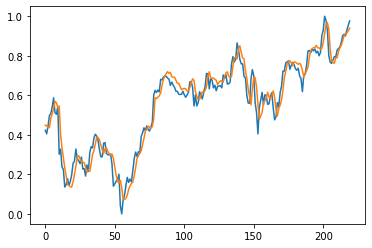

In [160]:
plt.plot(testY)
plt.plot(testPredict)

In [253]:
# 데이터 불러오기
df = pd.read_csv('data/삼성전자주가.csv', encoding='CP949')

# 컬럼명 저장
col = df.columns

# 날짜컬럼 제거
df = df.iloc[:,[1,2,3,4,5]]

# 배열로 변경
df = np.array(df)

# 데이터 역순으로 정렬
df = df[::-1]
df

array([[     130,      130,      129,      129,   111764],
       [     129,      129,      128,      128,   108496],
       [     129,      130,      128,      129,   771895],
       ...,
       [   56000,    56600,    54900,    55500, 15422255],
       [   54900,    55600,    54600,    55500, 10278951],
       [   55700,    56400,    55600,    55800,  9893846]], dtype=int64)

In [254]:
from sklearn.preprocessing import MinMaxScaler

In [255]:
scaler = MinMaxScaler()
df_n = scaler.fit_transform(df)
df_n

array([[2.43970445e-04, 2.43885444e-04, 2.47153323e-04, 2.27654805e-04,
        3.42181482e-04],
       [2.26543984e-04, 2.26465055e-04, 2.29499515e-04, 2.10142897e-04,
        3.32176032e-04],
       [2.26543984e-04, 2.43885444e-04, 2.29499515e-04, 2.27654805e-04,
        2.36326702e-03],
       ...,
       [9.73860309e-01, 9.83973242e-01, 9.67163916e-01, 9.69879518e-01,
        4.72174410e-02],
       [9.54691203e-01, 9.66552853e-01, 9.61867773e-01, 9.69879518e-01,
        3.14704796e-02],
       [9.68632371e-01, 9.80489165e-01, 9.79521582e-01, 9.75133091e-01,
        3.02914256e-02]])

In [256]:
# 변수 선언

seqLength = 14 # window size
dataDim = 5 # 시가, 종가, 거래량 .. 5개 컬럼
hiddenDim = 10  # 출력 수
outputDim = 1
lr = 0.01
iterations = 500

In [257]:
def buildDataSet(timeSeries, seqLength) :
    
    xdata = []
    ydata = []
    #                마지막 2주 데이터는 학습 x
    for i in range(len(timeSeries)-seqLength) :
        tx = timeSeries[i:i+seqLength, :]  # tempX
        ty = timeSeries[i+seqLength, [-1]]  # tempY
        
        xdata.append(tx)
        ydata.append(ty)
        
    return np.array(xdata), np.array(ydata)

In [258]:
trainX, trainY = buildDataSet(df_n, seqLength)

In [259]:
print(trainX.shape)
print(trainY.shape)

(9274, 14, 5)
(9274, 1)


In [260]:
tf.reset_default_graph()
#                                    14일치데이터의 행이 5개
x = tf.placeholder(tf.float32, shape=[None, seqLength, dataDim])
y = tf.placeholder(tf.float32, shape=[None, 1])

# rnn구조의 박스
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hiddenDim,
    state_is_tuple=True,    # output과 state를 튜플로 묶겠느냐?
                            # True = ([1,2],[3,4])
                            # False = [1,2,3,4]
    activation=tf.tanh
)

In [261]:
outputs, _states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

yhat = tf.contrib.layers.fully_connected(outputs[:, -1], outputDim, activation_fn=None)  # 맨 마지막 결과

In [262]:
# loss과 train노드
loss = tf.reduce_mean(tf.square(yhat - y))
train = tf.train.AdamOptimizer(lr).minimize(loss)

In [263]:
# RMSE
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None,1])

rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [264]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(iterations) :
    _, cv = sess.run([train, loss], feed_dict={x:trainX, y:trainY})
    
    print('Step : {}, loss : {}'.format(step, cv))

Step : 0, loss : 0.012450745329260826
Step : 1, loss : 0.001952863996848464
Step : 2, loss : 0.004746363032609224
Step : 3, loss : 0.006346417590975761
Step : 4, loss : 0.004358688835054636
Step : 5, loss : 0.002213322324678302
Step : 6, loss : 0.0017069493187591434
Step : 7, loss : 0.002575246850028634
Step : 8, loss : 0.0033212280832231045
Step : 9, loss : 0.003126267809420824
Step : 10, loss : 0.0023473971523344517
Step : 11, loss : 0.0016363459872081876
Step : 12, loss : 0.0013624042039737105
Step : 13, loss : 0.001509368885308504
Step : 14, loss : 0.0018193275900557637
Step : 15, loss : 0.0020138544496148825
Step : 16, loss : 0.001961504342034459
Step : 17, loss : 0.0017121592536568642
Step : 18, loss : 0.0014193380484357476
Step : 19, loss : 0.0012291792081668973
Step : 20, loss : 0.0012013091472908854
Step : 21, loss : 0.001291800756007433
Step : 22, loss : 0.0013964674435555935
Step : 23, loss : 0.0014228314394131303
Step : 24, loss : 0.0013438895111903548
Step : 25, loss : 0.0

Step : 204, loss : 0.0008186674676835537
Step : 205, loss : 0.000818596628960222
Step : 206, loss : 0.000818526023067534
Step : 207, loss : 0.0008184553007595241
Step : 208, loss : 0.0008183849276974797
Step : 209, loss : 0.0008183145546354353
Step : 210, loss : 0.0008182443561963737
Step : 211, loss : 0.0008181743905879557
Step : 212, loss : 0.0008181044831871986
Step : 213, loss : 0.000818034983240068
Step : 214, loss : 0.0008179651340469718
Step : 215, loss : 0.0008178956340998411
Step : 216, loss : 0.0008178263087756932
Step : 217, loss : 0.0008177570998668671
Step : 218, loss : 0.0008176882402040064
Step : 219, loss : 0.0008176192059181631
Step : 220, loss : 0.0008175502880476415
Step : 221, loss : 0.0008174817776307464
Step : 222, loss : 0.0008174132090061903
Step : 223, loss : 0.0008173448732122779
Step : 224, loss : 0.0008172767120413482
Step : 225, loss : 0.0008172084926627576
Step : 226, loss : 0.000817140331491828
Step : 227, loss : 0.0008170725195668638
Step : 228, loss : 0

Step : 405, loss : 0.0008061740663833916
Step : 406, loss : 0.0008061162661761045
Step : 407, loss : 0.0008060586405918002
Step : 408, loss : 0.000806000898592174
Step : 409, loss : 0.0008059432148002088
Step : 410, loss : 0.0008058856474235654
Step : 411, loss : 0.0008058282546699047
Step : 412, loss : 0.0008057705126702785
Step : 413, loss : 0.0008057131199166179
Step : 414, loss : 0.0008056554943323135
Step : 415, loss : 0.0008055981015786529
Step : 416, loss : 0.0008055407088249922
Step : 417, loss : 0.0008054834906943142
Step : 418, loss : 0.0008054259233176708
Step : 419, loss : 0.0008053688216023147
Step : 420, loss : 0.0008053113124333322
Step : 421, loss : 0.0008052541525103152
Step : 422, loss : 0.0008051969343796372
Step : 423, loss : 0.0008051397744566202
Step : 424, loss : 0.0008050826145336032
Step : 425, loss : 0.000805025571025908
Step : 426, loss : 0.0008049684693105519
Step : 427, loss : 0.0008049114840105176
Step : 428, loss : 0.0008048543240875006
Step : 429, loss :

RMSE value : 0.028300141915678978


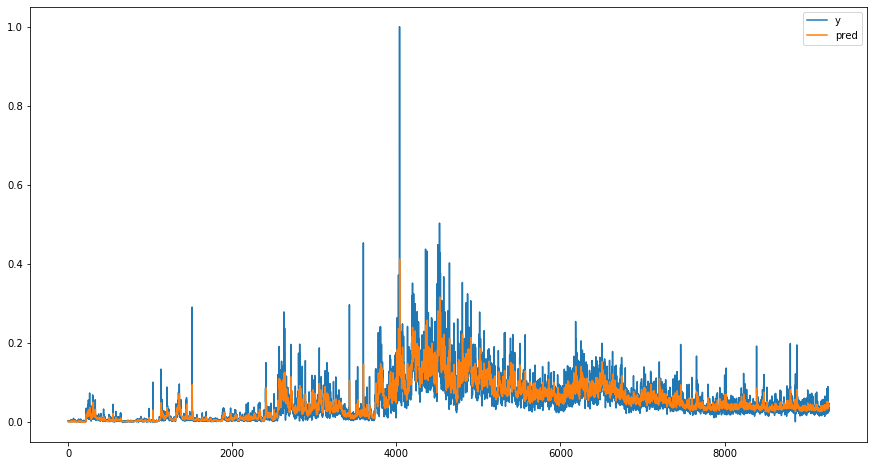

In [279]:
testPredict = sess.run(yhat, feed_dict={x:trainX})
rmsev = sess.run(rmse, feed_dict={targets:trainY, predictions:testPredict})

print('RMSE value : {}'.format(rmsev))

plt.figure(figsize=(15,8))
plt.plot(trainY, label='y')
plt.plot(testPredict, label='pred')
plt.legend()

In [266]:
# test셋 만들기
test = pd.read_csv('data/005930.KS.csv')

start_idx = test[test['Date']=='2020-01-09'].index[0]
end_idx = test[test['Date']=='2020-02-28'].index[0]

test = test.iloc[start_idx:end_idx,1:6]

test = np.array(test)
test = test[::-1]


test = sclaer.transform(test)
test

testX, testY = buildDataSet(test, seqLength)

In [267]:
testPredict = sess.run(yhat, feed_dict={x:testX})
rmsev = sess.run(rmse, feed_dict={targets:testY, predictions:testPredict})

print('RMSE value : {}'.format(rmsev))

RMSE value : 0.36999088525772095


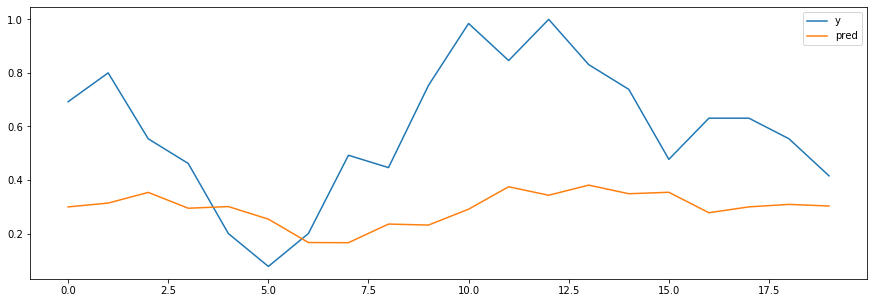

In [272]:
plt.figure(figsize=(15,5))

plt.plot(testY, label='y')
plt.plot(testPredict, label='pred')
plt.legend()